## Pruebas de seguimiento solar y demanda neta

In [40]:
built_n = "GHS_BUILT_S_E2020_GLOBE_R2023A_4326_30ss_V1_0"
built = xr.open_dataset(f"../data/{built_n}/{built_n}.tif"
    ).isel({"band": 0}).drop_vars(["band", "spatial_ref"]).rename(
    {"x": "lon", "y": "lat", "band_data": "built_surface"}
    ).sel( {
    "lon": slice(ds["lon"].values.min()-0.02, ds["lon"].values.max()+0.02),
    "lat": slice(ds["lat"].values.max()+0.02, ds["lat"].values.min()-0.03) } )
built = built.coarsen({"lon": 2, "lat": 2}).sum()
regridder = xe.Regridder(built, ds, method = "bilinear")
built = regridder(built, keep_attrs=True)

built

<xarray.Dataset> Size: 2kB
Dimensions:        (lat: 13, lon: 16)
Coordinates:
  * lon            (lon) float64 128B -100.5 -100.4 -100.4 ... -99.9 -99.86
  * lat            (lat) float64 104B 18.09 18.13 18.17 ... 18.49 18.53 18.57
Data variables:
    built_surface  (lat, lon) float64 2kB 5.372e+03 22.33 ... 1.007e+04
Attributes:
    regrid_method:  bilinear

In [58]:
prod_n_dist = [f"{x}_distributed" for x in prod_n]
ds[prod_n_dist] = ds[prod_n].copy()
for c in ds["NUM_CENACE"].values:
    ds[prod_n_dist] = xr.where( ds["NUM_CENACE"] == c,
        ( ds[prod_n_dist] * ds["built_surface"]
        / ds["built_surface"].where(ds["NUM_CENACE"] == c).sum() ),
        ds[prod_n_dist] )

# Funciones y datos

In [35]:
# Importamos librerías
import os
import rasterio
import numpy                           as np
import pandas                          as pd
import geopandas                       as gpd
import xarray                          as xr
import xesmf                           as xe
from   matplotlib        import pyplot as plt
from   scipy             import optimize
from   matplotlib.ticker import StrMethodFormatter

# Huso horario.
# La información está en UTC.
TZ = -6

In [5]:
# Funciones trigonométricas.
def sin(x) : return np.sin(np.radians(x))
def cos(x) : return np.cos(np.radians(x))
def tan(x) : return np.tan(np.radians(x))
def asin(x): return np.arcsin(x) * 180/np.pi
def acos(x): return np.arccos(x) * 180/np.pi
def atan(x): return np.arctan(x) * 180/np.pi

def NUM_CENACE(x):
    if   x == "BCA": y = 0
    elif x == "BCS": y = 1
    elif x == "CEN": y = 2
    elif x == "NES": y = 3
    elif x == "NOR": y = 4
    elif x == "NTE": y = 5
    elif x == "OCC": y = 6
    elif x == "ORI": y = 7
    elif x == "PEN": y = 8
    return y

def NUM_CENACE_r(x):
    if   x == 0: y = "BCA"
    elif x == 1: y = "BCS"
    elif x == 2: y = "CEN"
    elif x == 3: y = "NES"
    elif x == 4: y = "NOR"
    elif x == 5: y = "NTE"
    elif x == 6: y = "OCC"
    elif x == 7: y = "ORI"
    elif x == 8: y = "PEN"
    return y

def NAME_CENACE_r(x):
    if   x == 0: y = "México Baja California"
    elif x == 1: y = "México Baja California Sur"
    elif x == 2: y = "México Centro"
    elif x == 3: y = "México Noreste"
    elif x == 4: y = "México Noroeste"
    elif x == 5: y = "México Norte"
    elif x == 6: y = "México Occidente"
    elif x == 7: y = "México Oriente"
    elif x == 8: y = "México Peninsular"

In [6]:
# Datos de radiación

# Rutas de archivos
path_f = "../data/"
name_f = "NSRDB_4km_2022_00.nc"

# Cargamos archivos de radiación
ds = xr.open_dataset(path_f + name_f).drop_vars("UVHI")

# Convertimos a fecha.
ds["hour"] = ( ds["time"].dt.hour + ds["time"].dt.minute / 60 ).copy()
ds["dayofyear"] = ds["time"].dt.dayofyear.copy()

regiones = pd.read_csv( "../data/regiones_CENACE.csv",
    index_col = "CLAVE ENTIDAD" )
estados = gpd.read_file("../data/Mapas/dest23gw")
estados["CVE_ENT"] = estados["CVE_ENT"].astype(int)
estados = estados.set_index("CVE_ENT")
estados["REG_CENACE"] = regiones["REGION CENACE"]
estados["CVE_CENACE"] = regiones["CLAVE CENACE"]
estados["NUM_CENACE"] = regiones["CLAVE CENACE"].apply(NUM_CENACE)

points = ds.isel(time = 0)["Temperature"].to_dataframe(
    ).reset_index().drop( columns = ["time", "Temperature"] )
points["geometry"] = gpd.points_from_xy(points["lon"], points["lat"])
points = gpd.GeoDataFrame(points)
points["CVE_ENT"] = np.nan
for cve in estados.index:
    points["MASK_ENT"] = points.within(estados.loc[cve, "geometry"])
    points["CVE_ENT"] = points["CVE_ENT"].where( ~points["MASK_ENT"], cve )

points = pd.merge(points, estados["NUM_CENACE"].reset_index(), on = "CVE_ENT")

CENACE = points.set_index( ["lon", "lat"]
    )[ ["CVE_ENT", "NUM_CENACE"] ].to_xarray()

ds = xr.merge([ds, CENACE])
ds

<xarray.Dataset> Size: 73MB
Dimensions:      (time: 8760, lon: 16, lat: 13)
Coordinates:
  * time         (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * lon          (lon) float64 128B -100.5 -100.4 -100.4 ... -99.94 -99.9 -99.86
  * lat          (lat) float64 104B 18.09 18.13 18.17 ... 18.49 18.53 18.57
Data variables:
    Temperature  (time, lat, lon) float64 15MB ...
    DNI          (time, lat, lon) float64 15MB ...
    GHI          (time, lat, lon) float64 15MB ...
    Pressure     (time, lat, lon) float64 15MB ...
    Wind Speed   (time, lat, lon) float64 15MB ...
    hour         (time) float64 70kB 0.0 1.0 2.0 3.0 4.0 ... 20.0 21.0 22.0 23.0
    dayofyear    (time) int64 70kB 1 1 1 1 1 1 1 ... 365 365 365 365 365 365 365
    CVE_ENT      (lon, lat) float64 2kB 12.0 12.0 12.0 12.0 ... 12.0 12.0 12.0
    NUM_CENACE   (lon, lat) int64 2kB 7 7 7 7 7 7 7 7 7 7 ... 7 7 7 7 7 7 7 7 7
Attributes:
    CDI:                       Climate Data Interface version 2.4.0 (https://...
    Conventions:               CF-1.6
    history:                   Fri Sep 06 19:15:50 2024: cdo distgrid,5,5 NSR...
    cdo_openmp_thread_number:  2
    CDO:                       Climate Data Operators version 2.4.0 (https://...

# Producción fotovoltaica

In [7]:
# Cálculo de posición solar

lat = ds["lat"]
lon = ds["lon"]

# Eccentric anomaly of the earth in its orbit around the sun.
ds["Day_Angle"] = 6.283185 * ( ds["dayofyear"] - 1 ) / 365
# Declinación.
ds["Declination"] = ( ( 0.006918 - 0.399912 * np.cos(ds["Day_Angle"])
    + 0.070257*np.sin(ds["Day_Angle"])
    - 0.006758*np.cos(2*ds["Day_Angle"])
    + 0.000907*np.sin(2*ds["Day_Angle"])
    - 0.002697*np.cos(3*ds["Day_Angle"])
    + 0.00148*np.sin(3*ds["Day_Angle"]) ) * 180/np.pi )
# Ecuación del tiempo.
ds["Time_Equation"] = ( ( 0.000075 + 0.001868*np.cos(ds["Day_Angle"])
    - 0.032077*np.sin(ds["Day_Angle"])
    - 0.014615*np.cos(2*ds["Day_Angle"])
    -0.040849*np.sin(2*ds["Day_Angle"])) * 229.18 )
# Longitud del punto subsolar.
ds["lon_subs"] = -15 * ( ds["hour"] - TZ
    + ds["Time_Equation"]/60 )
# Ángulo horario.
ds["Hour_Angle"] = ( 15 * ( ds["hour"] - 12
    - ds["Time_Equation"]/60 + ((lon-TZ*15)*4)/60 ) )
ds = ds.drop_vars( ["Time_Equation"] )
# Posiciones del analema solar.
ds["Sz"] = ( sin(lat)*sin(ds["Declination"])
    - cos(lat)*cos(ds["Declination"])
    *cos(ds["lon_subs"]-lon) )
ds = ds.drop_vars( ["lon_subs"] )
# Ángulo del cénit solar.
ds["Zenith_Angle"] = acos(ds["Sz"])
ds = ds.drop_vars( "Sz" )
# Ángulo acimutal solar.
ds["Azimuth_Angle"] = acos( ( sin(ds["Declination"])
    - cos(ds["Zenith_Angle"])*sin(lat) )
    / ( sin(ds["Zenith_Angle"])*cos(lat) ) )
ds["Azimuth_Angle"] = ds["Azimuth_Angle"].where(
    ds["Hour_Angle"] < 0, 360 - ds["Azimuth_Angle"] )
ds = ds.drop_vars( ["Declination", "Hour_Angle"] )
# Masa de aire.
ds["Air_Mass"] = ( 1/(cos(ds["Zenith_Angle"])
    + 0.15/(93.885 - ds["Zenith_Angle"])**1.253 )
    * ds["Pressure"]/1013.25 )
ds["Air_Mass"] = ds["Air_Mass"].where( ds["Zenith_Angle"] < 85.5, 0 )
ds = ds.drop_vars( ["Day_Angle", "Pressure"] )

In [8]:
# Casos de orientación de sistemas fotovoltaico

# Casos a estudiar
cases = [ "south_no_track", "west_no_track", "east_no_track",
    "1_track", "2_track", "bifacial_vertical_west_main",
    "bifacial_vertical_east_main", "bifacial_vertical_west_back",
    "bifacial_vertical_east_back", "bifacial_south_back" ]
names_dn = ["South-facing", "West-facing", "East-facing",
    "1 axis tracking", "2 axis tracking", "Bifacial, vertical, west-facing",
    "Bifacial, vertical, east-facing", "Bifacial, south facing", ]
# Variables fotovoltaicas por caso
# Inclinación
track_tilt       =   [ f"{x}_Tilt"               for x in cases ]
# Azimuth
track_azimuth    =   [ f"{x}_Azimuth"            for x in cases ]
# Ángulo entre el panel y el sol, Angle of Incidence
track_AOI        =   [ f"{x}_Angle_of_Incidence" for x in cases ]
# Radiación incidente en el panel [W/m^2], Plane of Array Irradiace
track_POA        =   [ f"{x}_POA"                for x in cases ]
# Producción fotovoltaica por kilowatt de capacidad [W/kWp]
track_P_mp       = ( [ f"{x}_P_mp"               for x in cases ]
    + [ "bifacial_vertical_west_P_mp",
        "bifacial_vertical_east_P_mp",
        "bifacial_south_P_mp" ] )
# Producción para cada caso
prod_n           = track_P_mp[0:5] + track_P_mp[10:]
# Demanda neta [GW]
track_net_demand = ( [ f"{x}_net_demand"         for x in cases[0:5] ]
    + [ "bifacial_vertical_west_net_demand",
        "bifacial_vertical_east_net_demand",
        "bifacial_south_net_demand" ] )
# Factor bifacial
P_bf = [ 1, 1, 1, 1, 1, 1, 1, 0.7, 0.7, 0.7 ]

# Ángulos de orientación de los sistemas
# Orientación del seguidor de un eje
# Asumimos inclinación de 0 grados
azimuth_tracker = 180
# south_no_track
ds[track_azimuth[0]] = 180
ds[track_tilt[0]   ] = lat
# west_no_track
ds[track_azimuth[1]] = 270
ds[track_tilt[1]   ] = lat
# east_no_track
ds[track_azimuth[2]] = 90
ds[track_tilt[2]   ] = lat
# 1_track
ds[track_tilt[3]   ] = np.abs( atan( tan(ds["Zenith_Angle"])
    * sin(ds["Azimuth_Angle"] - azimuth_tracker) ) )
ds[track_azimuth[3]] = 90
ds[track_azimuth[3]] = ds["1_track_Azimuth"
    ].where(ds["Azimuth_Angle"]<180, 270)
# 2_track
ds[track_tilt[4]   ] = ds["Zenith_Angle"]
ds[track_azimuth[4]] = ds["Azimuth_Angle"]
# bifacial_vertical_west_main
ds[track_tilt[5]   ] = 90
ds[track_azimuth[5]] = 270
# bifacial_vertical_east_main
ds[track_tilt[6]   ] = 90
ds[track_azimuth[6]] = 90
# bifacial_vertical_west_back
ds[track_tilt[7]   ] = 90
ds[track_azimuth[7]] = 90
# bifacial_vertical_east_back
ds[track_tilt[8]   ] = 90
ds[track_azimuth[8]] = 270
# bifacial_south_back
ds[track_tilt[9]   ] = 90 + lat
ds[track_azimuth[9]] = 0

In [9]:
# Producción fotovoltaica

# Modelo de Pérez de Cielo Difuso para calcular 
# la radiación en un plano inclinado
# Diffuse Horizontal Radiation.
ds["DHI"] = ds["GHI"] - ds["DNI"] * cos(ds["Zenith_Angle"])
ds["DHI"] = ds["DHI"].where(ds["DHI"]>0, 0.001)
K = 5.535e-6
# Perez clearness bins.
ds["bins"] = 0
ds["bins"] = ds["bins"].where( ds["DHI"] == 0.001,
    ( (ds["DHI"]+ds["DNI"])/ds["DHI"] + K*ds["Zenith_Angle"]**3 )
    / ( 1 + K*ds["Zenith_Angle"]**3 ) )
ds["DHI"] = ds["DHI"].where(ds["DHI"]>0.001, 0)
ds["epsilon"] = ds["bins"   ].where( ds["bins"] < 6.200, 8 )
ds["epsilon"] = ds["epsilon"].where( 
    ~( (ds["bins"]>4.500) & (ds["bins"]<6.200) ), 7 )
ds["epsilon"] = ds["epsilon"].where( 
    ~( (ds["bins"]>2.600) & (ds["bins"]<4.500) ), 6 )
ds["epsilon"] = ds["epsilon"].where( 
    ~( (ds["bins"]>1.950) & (ds["bins"]<2.600) ), 5 )
ds["epsilon"] = ds["epsilon"].where( 
    ~( (ds["bins"]>1.500) & (ds["bins"]<1.950) ), 4 )
ds["epsilon"] = ds["epsilon"].where( 
    ~( (ds["bins"]>1.230) & (ds["bins"]<1.500) ), 3 )
ds["epsilon"] = ds["epsilon"].where( 
    ~( (ds["bins"]>1.065) & (ds["bins"]<1.500) ), 2 )
ds["epsilon"] = ds["epsilon"].where( ds["bins"] > 1.065, 1 )
Perez = pd.read_csv("../code/Perez.csv", index_col = "bin" )
ds = ds.drop_vars( "bins" )
# Extraterrestrial radiation.
Ea = 1367
# Coeficientes
ds["Delta"] = ds["DHI"] * ds["Air_Mass"] / Ea
ds = ds.drop_vars( "Air_Mass" )
for j in Perez.columns:
    ds[j] = 0.0
    for i in Perez.index:
        ds[j] = ds[j].where(ds["epsilon"] != i, Perez.loc[i, j] )
ds = ds.drop_vars( "epsilon" )
ds["F1"] = ( ds["f11"] + ds["f12"]*ds["Delta"]
    + np.radians(ds["Zenith_Angle"])*ds["f13"] )
ds = ds.drop_vars( ["f11", "f12", "f13"] )
ds["F1"] = ds["F1"].where( ds["F1"] < 0, 0 )
ds["F2"] = ( ds["f21"] + ds["f22"]*ds["Delta"]
    + np.radians(ds["Zenith_Angle"])*ds["f23"] )
ds = ds.drop_vars( ["f21", "f22", "f23", "Delta"] )
ds["b"] = cos(ds["Zenith_Angle"])
ds["b"] = ds["b"].where( ds["b"] < cos(85), cos(85) )
# Iteramos para cada caso
for i in range(len(cases)):
    # Ángulo entre el panel y el sol, Angle of Incidence
    ds[track_AOI[i]] = (
        cos(ds["Zenith_Angle"])*cos(ds[track_tilt[i]])
        + sin(ds["Zenith_Angle"])*sin(ds[track_tilt[i]])
        *cos(ds["Azimuth_Angle"]-ds[track_azimuth[i]]) )
    ds[track_AOI[i]] = ds[track_AOI[i]].where( ds[track_AOI[i]] < 1, 1 )
    ds[track_AOI[i]] = ds[track_AOI[i]].where( ds[track_AOI[i]] > -1, -1 )
    ds[track_AOI[i]] = acos(ds[track_AOI[i]])
    ds["a"] = cos(ds[track_AOI[i]])
    ds["a"] = ds["a"].where( ds["a"] < 0, 0 )
    # Radiación difusa.
    ds["I_d"] = ( ds["DHI"] * ( (1-ds["F1"])*((1+cos(ds[track_tilt[i]]))/2)
        + ds["F1"]*ds["a"]/ds["b"] + ds["F2"]*sin(ds[track_tilt[i]]) ) )
    ds["I_d_90"] = ( ds["DHI"] * ((1+cos(ds[track_tilt[i]]))/2) )
    ds["I_d"] = ds["I_d"].where( ds["Zenith_Angle"] < 87.5, ds["I_d_90"] )
    ds = ds.drop_vars( "I_d_90" )
    ds["I_d"] = ds["I_d"].where( ds["Zenith_Angle"] < 90, 0 )
    # Radiación directa.
    ds["I_b"] = ds["DNI"] * cos(ds[track_AOI[i]])
    ds["I_b"] = ds["I_b"].where( ds[track_AOI[i]] < 90, 0 )
    ds = ds.drop_vars( track_AOI[i] )
    # Radiación total en el panel.
    ds[track_POA[i]] = ds["I_b"] + ds["I_d"]
    ds = ds.drop_vars( ["I_b", "I_d"] )

ds = ds.drop_vars( ["F1", "F2", "a", "b", 
    "Zenith_Angle", "Azimuth_Angle", "DHI"] )

# NOCT Cell Temperature Model
T_NOCT    = 44 # °C
# Datos de Panel Canadian Solar 550 W
# Modelo: HiKu6 Mono PERC CS6W-550
I_mp      = 13.2 # A
V_mp      = 41.7 # V
A_m       = 1.134*2.278 # m^2
eff_ref   = I_mp * V_mp / (1000 * A_m)
tau_alpha = 0.9
# Ajuste de viento.
#v = 0.61 # Dos pisos.
v = 0.51 # Un piso.
# Ajuste de montaje.
T_adj = 2   + T_NOCT # Building integrated,
# greater than 3.5 in, or ground/rack mounted
#T_adj = 2  + T_NOCT # 2.5 to 3.5 in
#T_adj = 6  + T_NOCT # 1.5 to 2.5 in
#T_adj = 11 + T_NOCT # 0.5 to 1.5 in
#T_adj = 18 + T_NOCT # less than 0.5 in
# Iteramos para cada caso
for i in range(len(cases)):
    # Temperatura de la celda
    ds[cases[i] + "_Cell_Temperature"] = ( ds["Temperature"]
        + ds[track_POA[i]] / 800 * (T_adj-20)
        * (1-eff_ref/tau_alpha) * ( 9.5 / (5.7+3.8*v*ds["Wind Speed"]) ) )
ds = ds.drop_vars(["Wind Speed", "Temperature"])

# Simple efficiency module model
# Eficiencia por temperatura
eff_T = -0.34
# Pérdidas del sistema
eff_n = [ "Soiling", "Shading", "Snow", "Mismatch",
    "Wiring", "Connections", "Light_Induced_Degradation",
    "Nameplate_Rating", "Age", "Availability" ]
eff = np.array( [0.98, 0.97, 1, 0.98, 0.98,
    0.995, 0.985, 0.99, 1, 0.97] ).prod()
# Eficiencia del inversor
eff_inv = 0.96
# Eficiencia del sistema
eff_sys = eff_ref * eff_inv * eff
# DC to AC Size Ratio
DC_AC = 1.1
# Inverter size
inv_P = I_mp * V_mp / DC_AC

# Iteramos para cada caso
for i in range(len(cases)):
    # Potencia generada en AC
    ds[track_P_mp[i]] = ( P_bf[i] * ds[track_POA[i]]*eff_sys*A_m *
        ( 1 + eff_T/100 * (ds[cases[i] + "_Cell_Temperature"]-25) ) )
    ds[track_P_mp[i]] = ds[ track_P_mp[i] ].where(
        ds[track_P_mp[i]] < inv_P, inv_P )
    # El resultando es la generación por cada kWp.
    ds[track_P_mp[i]] = ds[track_P_mp[i]] * 1000 / ( I_mp * V_mp )
    ds[track_P_mp[i]] = ds[track_P_mp[i]].where(
        ds[track_POA[i]] > 0, 0 ).where(ds["GHI"] > 0, 0)
    ds = ds.drop_vars( cases[i] + "_Cell_Temperature" )
    ds = ds.drop_vars( track_POA[i] )

# Calculamos la producción bifacial total
ds[track_P_mp[10]] = ds[track_P_mp[5]] + ds[track_P_mp[7]]
ds[track_P_mp[11]] = ds[track_P_mp[6]] + ds[track_P_mp[8]]
ds[track_P_mp[12]] = ds[track_P_mp[0]] + ds[track_P_mp[9]]
ds = ds.drop_vars(track_P_mp[5:10])

#print("Photovoltaic production")
#pd.options.display.float_format = "{:,.0f} kWh/kWp".format
#a = ( ds[prod_n] / 2 ).sum(axis = 0)
#a.index = names_dn
#print(a.sort_values(ascending = False).to_string())

# Demanda

In [10]:
# Cargamos la demanda

# Ruta de la demanda para México
path_f = "../data/Demanda/Mexico/Original/"

# Cargamos cada archivo
df_i = []
for f in os.listdir(path_f):
    if f[0] != ".":
        df_0 = pd.read_csv(path_f + f, skiprows = 8,
            na_values = "               ---" )
        # Asignamos columnas
        df_0.columns = ['Sistema', 'Area', 'Hora', 'Generacion (MWh)',
           'Importacion Total (MWh)', 'Exportacion Total (MWh)',
            'Intercambio neto entre Gerencias (MWh)',
            'Estimacion de Demanda por Balance (MWh)']
        df_0["Area"] = df_0["Area"].where(df_0["Area"]!="BCA", df_0["Sistema"]) 
        df_0 = df_0.drop(columns = "Sistema")
        # Damos formato a la fecha
        df_0["Hora"] = df_0["Hora"].where(df_0["Hora"] < 25, np.nan)
        #df_0 = df_0.dropna()
        df_0["Hora"] = df_0["Hora"].where(df_0["Hora"] < 24, 0)
        df_0["Date"] = pd.to_datetime( df_0["Hora"].apply(
            lambda x: f"{f[40:50]} {x:02.0f}:00:00" ) )
        
        df_i.append(df_0.rename(columns = {"Date": "time"}).set_index("time"))

# Unimos todos los archivos
demanda = "Estimacion de Demanda por Balance (MWh)"
a = pd.concat(df_i)
a["NUM_CENACE"] = a["Area"].apply(NUM_CENACE)
a = a.set_index( "NUM_CENACE", append = True)[[demanda]].sort_index()
ds_d = a.loc[ ~a.index.duplicated() ].to_xarray()
ds_d = ds_d.rename_vars({demanda: "Demand"})
#ds_d = ds_d.interp_like(ds)

ds_c = ds.groupby("NUM_CENACE").mean().drop_vars("CVE_ENT")
ds_c["Demand"] = ds_d["Demand"]

In [11]:
# Minimun capacity to reach zero net demand during duck's belly
prod_n_cap = [f"{x}_capacity" for x in prod_n]
# Función que determina la demanda mínima en términos de la capacidad
def demand(x, v, c):
    return (ds_c["Demand"] - ds_c[v] * x).sel({"NUM_CENACE": c}).pipe(np.min)
# Encontramos la capacidad que ocasiona una demanda nula
for i, v in enumerate(prod_n):
    n = []
    for c in ds_c["NUM_CENACE"].values:
        n.append( optimize.fsolve(demand, x0 = 5, args = (v, c))[0] )
    ds_c[prod_n_cap[i]] = ("NUM_CENACE", n)
ds_c["min_capacity"] = ( "NUM_CENACE",
    ds_c[prod_n_cap].to_dataframe().min(axis = 1).values )

# Net demand with capacity that produces zero demand
ds_c[track_net_demand] = ( ds_c["Demand"]
    - ds_c[prod_n] * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, prod_n))) )
# Net demand with same capacity for all cases
prod_dn_min = [f"{x}_min" for x in track_net_demand]
ds_c[prod_dn_min] = ( ds_c["Demand"]
    - ds_c[prod_n] * ds_c["min_capacity"] )
# Energy produced
ener = [ f"{x}_energy" for x in prod_n ]
ds_c[ener] = ( ds_c[prod_n]
    * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, prod_n))) #/ 2
    ).sum("time")
# Demand ramp
track_net_demand_dt = [ f"{x}_dt" for x in track_net_demand ]
ds_c[track_net_demand_dt] = ( ds_c[track_net_demand]
    - ds_c[track_net_demand].shift(time = 1) ) #* 2
ds_c["Demand_dt"] = ( ds_c["Demand"]
    - ds_c["Demand"].shift(time = 1) ) #* 2
# Capacity factor
cap_f = [ f"{x}_capacity_factor" for x in prod_n ]
ds_c[cap_f] = ( 100 * ds_c[ener] / ( 1000 * 24 * 365
    * ds_c[prod_n_cap].rename(dict(zip(prod_n_cap, ener))) ) )

# Demanda máxima
track_net_demand_max = [f"{x}_max_demand" for x in ["No_PV"] + names_dn]
ds_c[track_net_demand_max] = ds_c[ ["Demand"] + track_net_demand
    ].pipe(np.abs).max("time")
# Demanda mínima
track_net_demand_min = [f"{x}_min_demand" for x in ["No_PV"] + names_dn]
ds_c[track_net_demand_min] = ds_c[ ["Demand"] + track_net_demand
    ].pipe(np.abs).min("time")
# Rampa máxima
track_net_demand_max_dt = [f"{x}_max_ramp" for x in ["No_PV"] + names_dn]
ds_c[track_net_demand_max_dt] = ds_c[ ["Demand"] + track_net_demand_dt
    ].pipe(np.abs).max("time")
# Rampa mínima
track_net_demand_min_dt = [f"{x}_min_ramp" for x in ["No_PV"] + names_dn]
ds_c[track_net_demand_max_dt] = ds_c[ ["Demand"] + track_net_demand_dt
    ].pipe(np.abs).min("time")

# Resumen por región

In [12]:
c = 7
reg = NAME_CENACE_r(c)

df = ds_c.sel({"NUM_CENACE": c}).drop_vars("NUM_CENACE").to_dataframe()

print(f"Photovoltaic production, {reg}")
pd.options.display.float_format = "{:,.0f} kWh/kWp".format
a = ( df[prod_n] / 2 ).sum(axis = 0)
a.index = names_dn
print(a.sort_values(ascending = False).to_string())

Photovoltaic production, None
2 axis tracking                   1,087,967 kWh/kWp
1 axis tracking                   1,032,930 kWh/kWp
Bifacial, south facing              972,805 kWh/kWp
South-facing                        882,697 kWh/kWp
East-facing                         842,150 kWh/kWp
West-facing                         808,433 kWh/kWp
Bifacial, vertical, east-facing     680,549 kWh/kWp
Bifacial, vertical, west-facing     659,401 kWh/kWp


/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_15121/1498703837.py:32: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_15121/1498703837.py:35: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_15121/1498703837.py:38: MatplotlibDeprecationWarning: An artist whose label starts with an unders

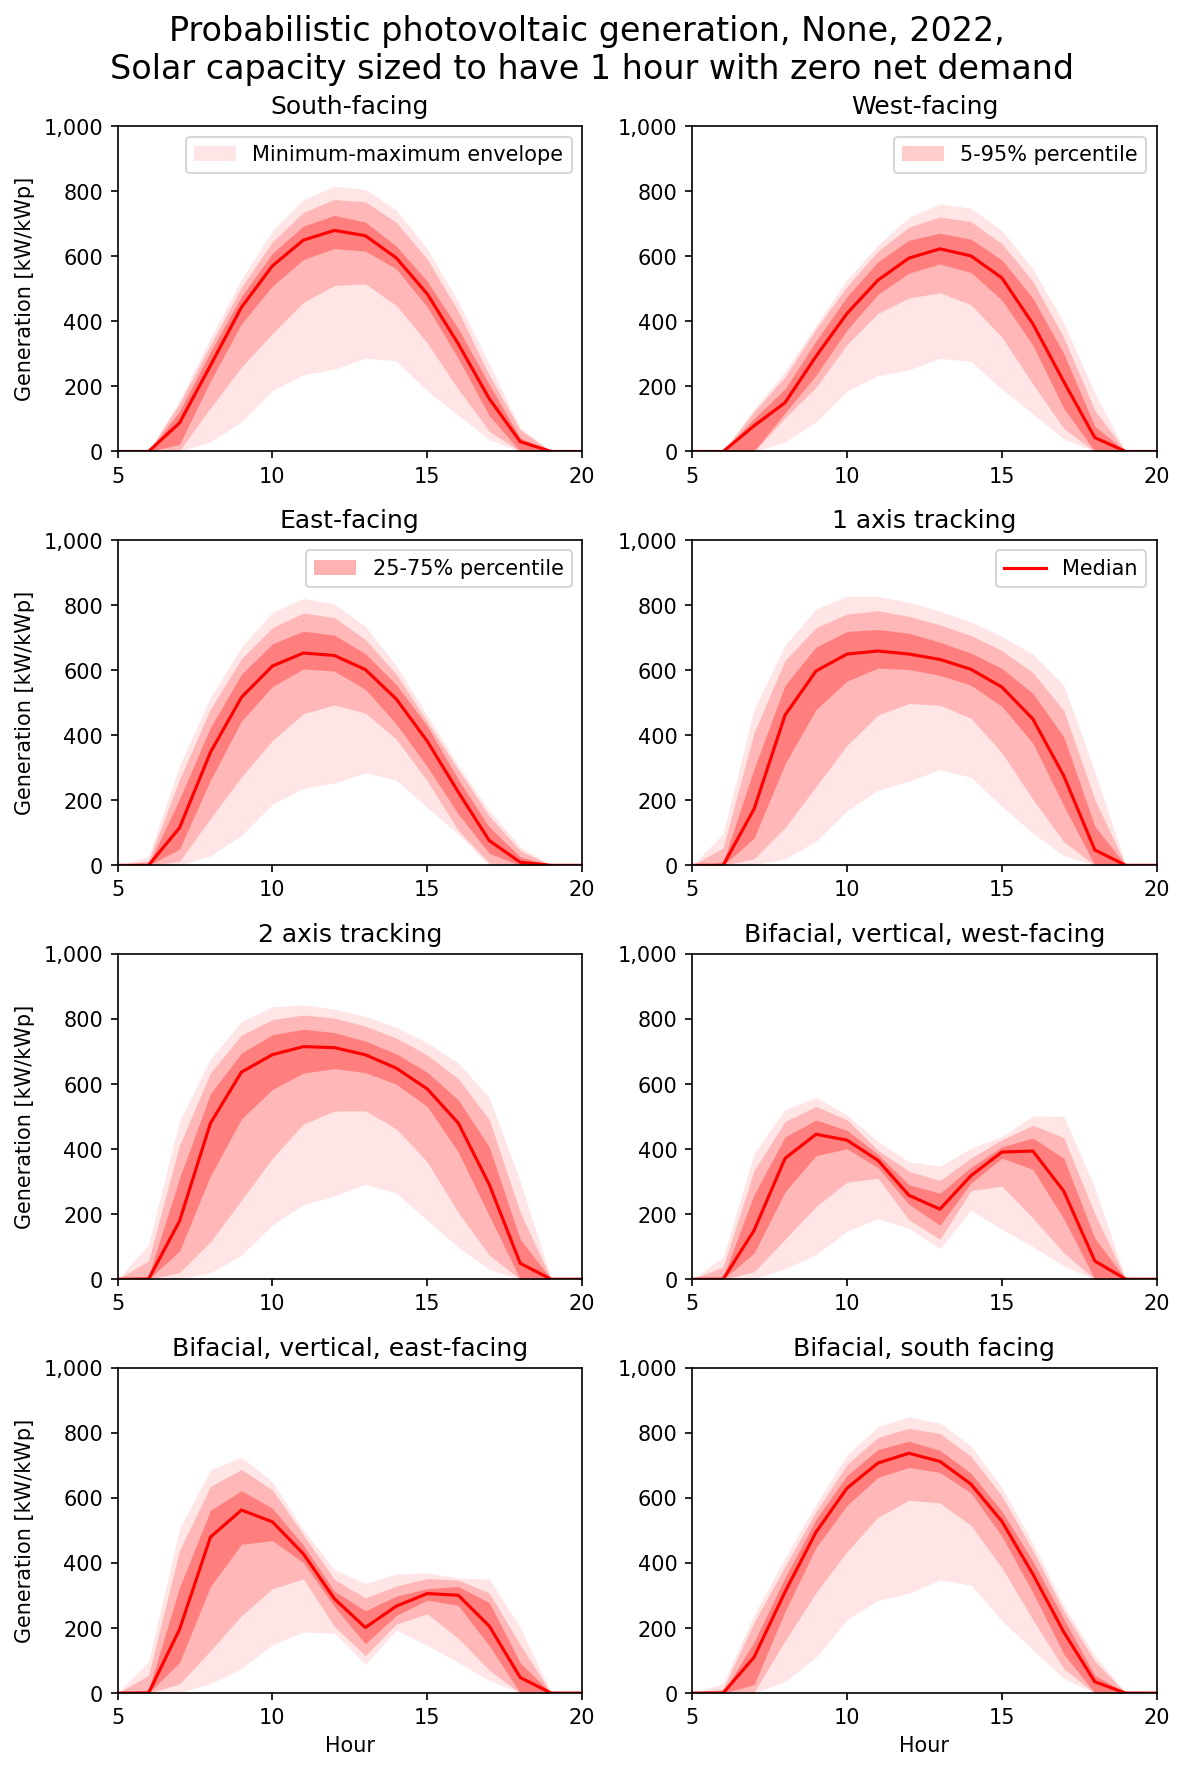

In [13]:
# Gráfica de producción fotovoltaica

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos los datos
    a = df[ ["hour", "dayofyear", prod_n[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = prod_n[i] )
    b = a.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1], axis = 1).T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(5, 20)
    ax.set_ylim(0, 1000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    if i%2 == 0: ax.set_ylabel("Generation [kW/kWp]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic photovoltaic generation, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

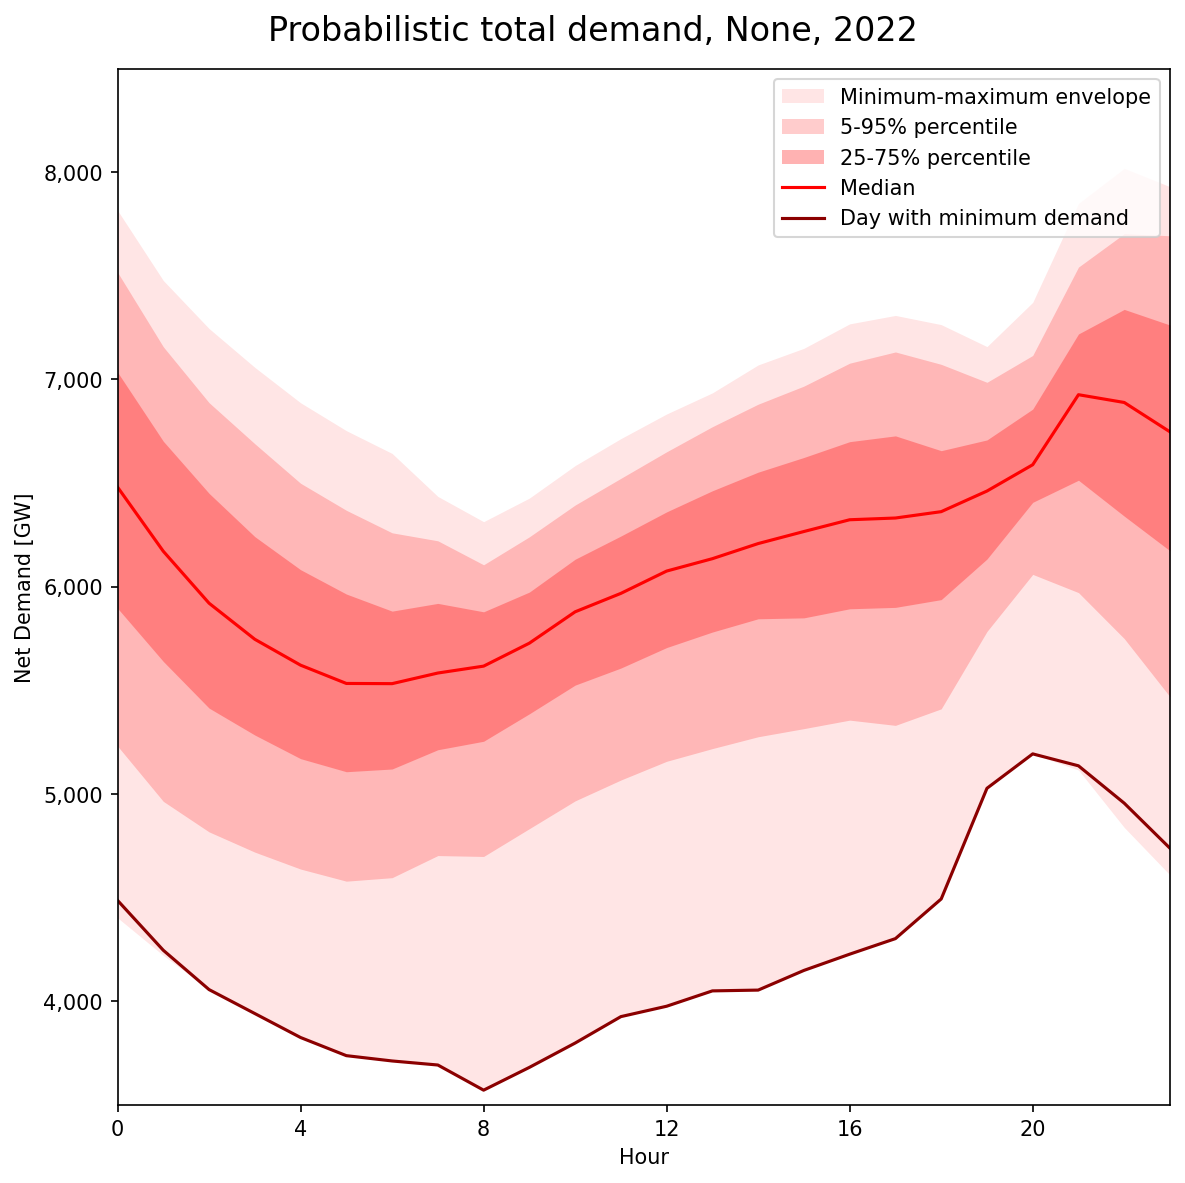

In [14]:
# Gráfica de demanda total

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Procesamos datos
a = df[ ["hour", "dayofyear", "Demand"]
    ].reset_index(drop = True).pivot( index = "hour",
    columns = "dayofyear", values = "Demand" )
b = a.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1], axis = 1).T

# Graficamos
ax.fill_between(b.index, b[1], b[0],
    color = "red", alpha = 0.1, linewidth = 0)
ax.fill_between(b.index, b[0.95], b[0.05],
    color = "red", alpha = 0.2, linewidth = 0)
ax.fill_between(b.index, b[0.75], b[0.25],
    color = "red", alpha = 0.3, linewidth = 0)
ax.plot(b.index, b[0.5], color = "red")
ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

# Formato de gráfica
ax.legend( ["Minimum-maximum envelope", "5-95% percentile",
    "25-75% percentile", "Median", "Day with minimum demand"] )
ax.set_xlim(0, 23)
ax.set_ylim(3500, 8500)
ax.xaxis.set_major_locator(plt.MultipleLocator(4))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Net Demand [GW]")
ax.set_xlabel("Hour")
fig.suptitle(f"Probabilistic total demand, {reg}, 2022",
    fontsize = 16)
fig.tight_layout()
plt.show()

/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_15121/1519927194.py:33: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "5-95% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_15121/1519927194.py:36: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["_", "_", "25-75% percentile"],
/var/folders/td/smccb02154l21rhgckcmbs940000gn/T/ipykernel_15121/1519927194.py:39: MatplotlibDeprecationWarning: An artist whose label starts with an unders

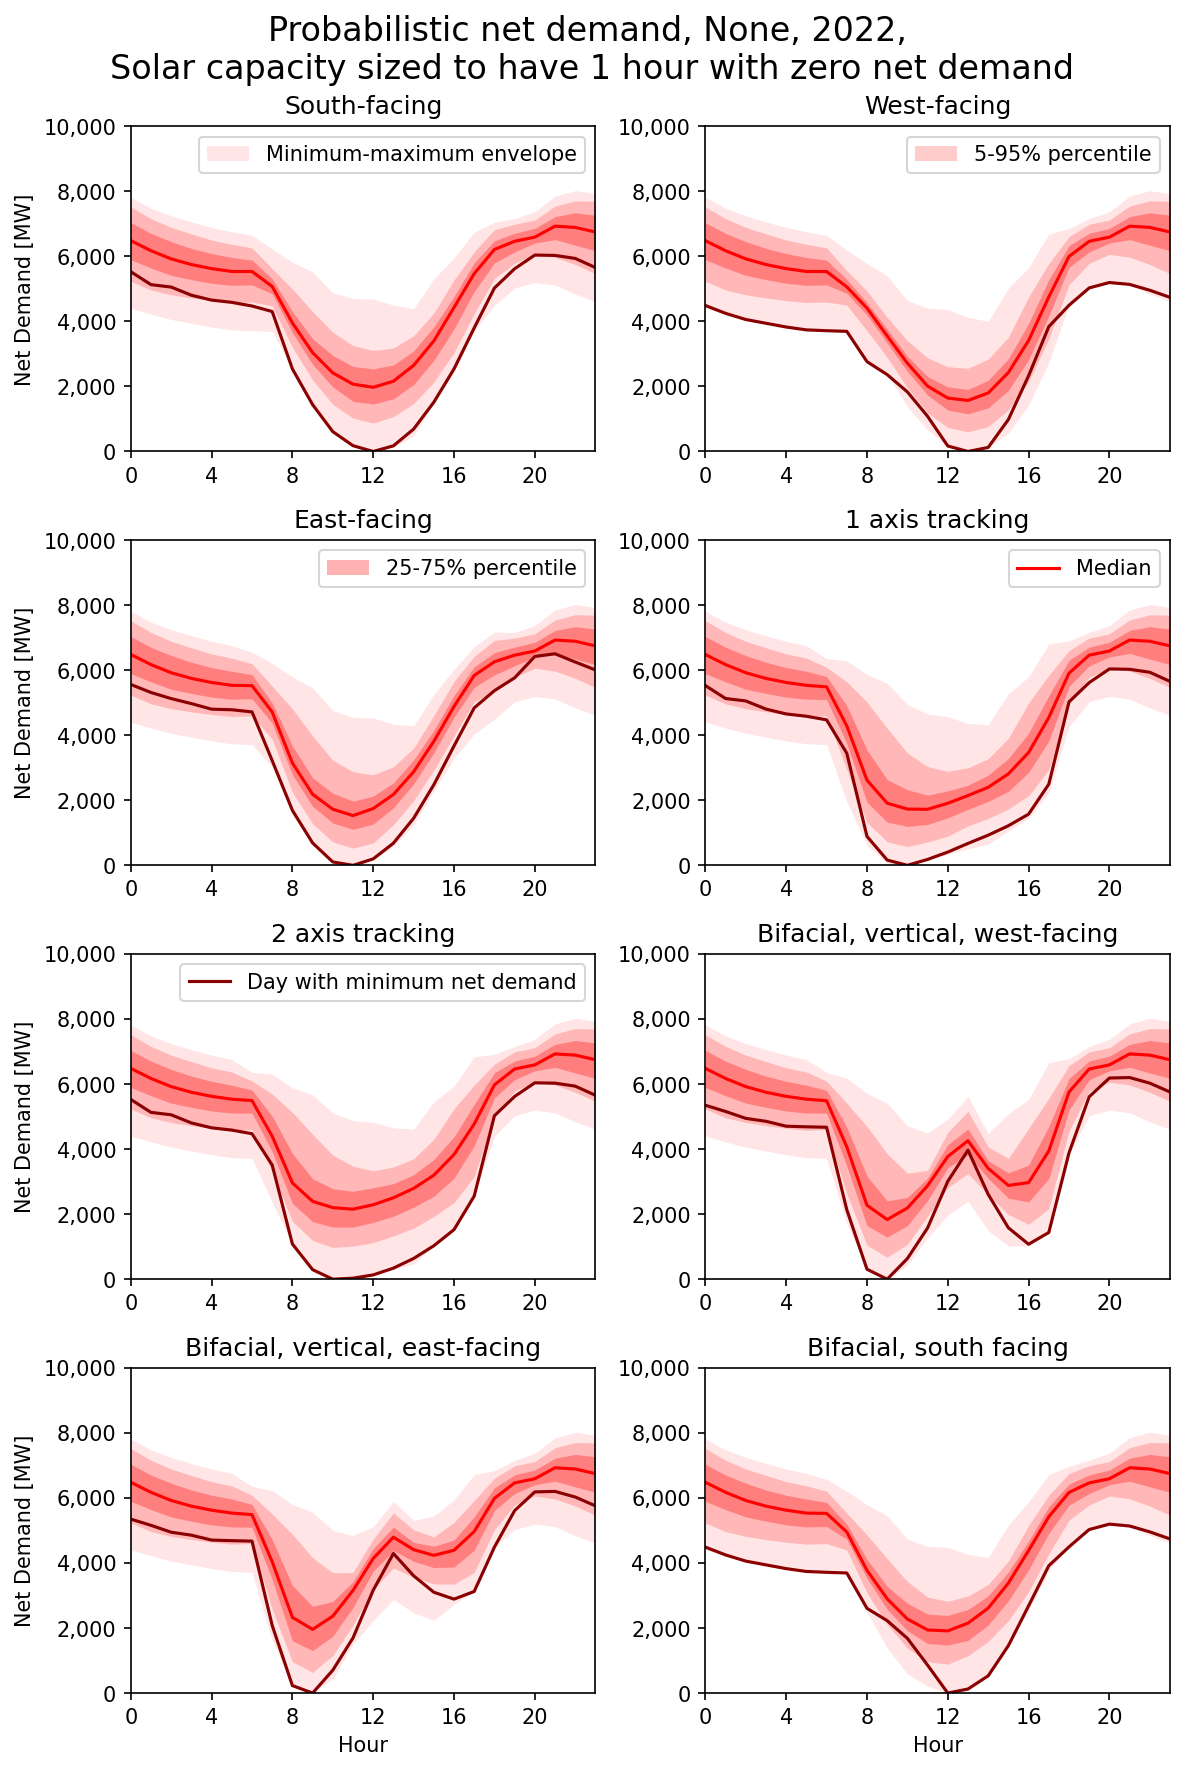

In [15]:
# Gráfica de demanda neta

# Incializamos gráfica
fig, axes = plt.subplots(4, 2)
axes = fig.axes
fig.set_facecolor("w")
fig.set_size_inches(8, 12)
fig.set_dpi(150) 

# Iteramos para cada gráfica
for i, ax in enumerate(axes):
    # Procesamos datos
    a = df[ ["hour", "dayofyear", track_net_demand[i]]
        ].reset_index(drop = True).pivot( index = "hour",
        columns = "dayofyear", values = track_net_demand[i] )
    b = a.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1], axis = 1).T

    # Graficamos
    ax.fill_between(b.index, b[1], b[0],
        color = "red", alpha = 0.1, linewidth = 0)
    ax.fill_between(b.index, b[0.95], b[0.05],
        color = "red", alpha = 0.2, linewidth = 0)
    ax.fill_between(b.index, b[0.75], b[0.25],
        color = "red", alpha = 0.3, linewidth = 0)
    ax.plot(b.index, b[0.5], color = "red")
    ax.plot(a.index, a[ a.min().sort_values().index[0] ], color = "darkred")

    # Formato de gráfica
    if   i == 0:
        ax.legend( ["Minimum-maximum envelope"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 1:
        ax.legend( ["_", "5-95% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 2:
        ax.legend( ["_", "_", "25-75% percentile"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 3:
        ax.legend( ["_", "_", "_", "Median"],
            prop = { "size": 10 }, ncol = 2 )
    elif i == 4:
        ax.legend( ["_", "_", "_", "_", "Day with minimum net demand"],
            prop = { "size": 10 }, ncol = 2 )
    ax.set_title(names_dn[i])
    ax.set_xlim(0, 23)
    ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    if i%2 == 0: ax.set_ylabel("Net Demand [MW]")
    if len(axes) - i <= 2: ax.set_xlabel("Hour")

# Formato de toda la gráfica
fig.suptitle(f"Probabilistic net demand, {reg}, 2022, \n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

Maximum load
No PV                             8,018 MW
South-facing                      8,018 MW
West-facing                       8,018 MW
East-facing                       8,018 MW
1 axis tracking                   8,018 MW
2 axis tracking                   8,018 MW
Bifacial, vertical, west-facing   8,018 MW
Bifacial, vertical, east-facing   8,018 MW
Bifacial, south facing            8,018 MW

Minimum load
Bifacial, vertical, east-facing      11 MW
West-facing                          28 MW
East-facing                          30 MW
2 axis tracking                      31 MW
1 axis tracking                      53 MW
Bifacial, vertical, west-facing      58 MW
South-facing                        174 MW
Bifacial, south facing              211 MW
No PV                             3,572 MW


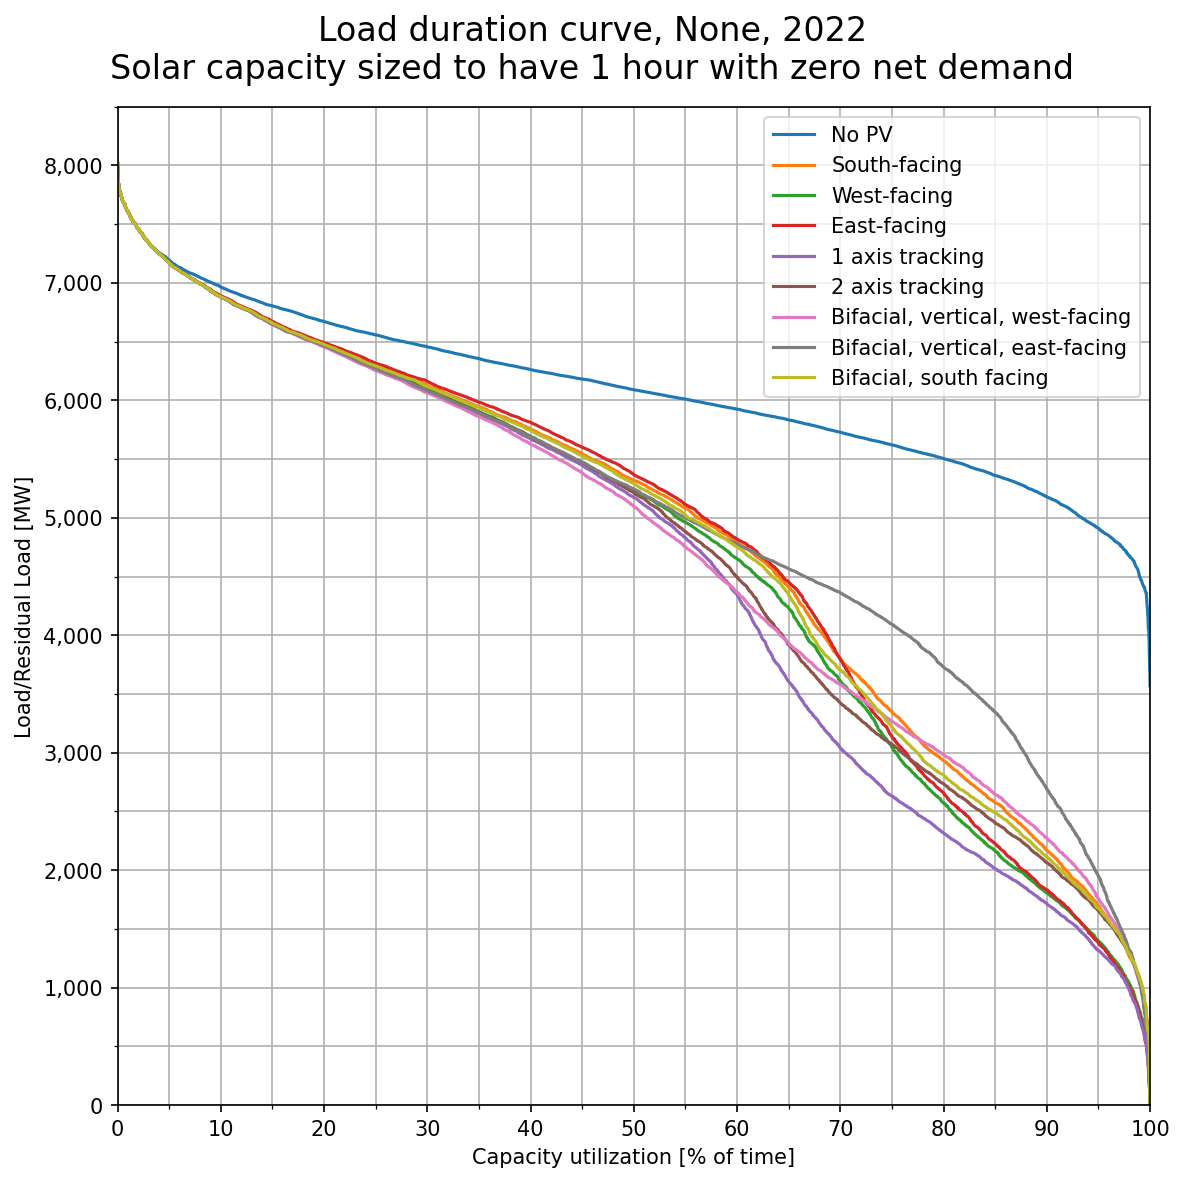

In [16]:
# Load duration curve

# Demandas máxima y mínima
b = df[["Demand"] + track_net_demand].max(axis = 0)
b.index = ["No PV"] + names_dn
pd.options.display.float_format = '{:,.0f} MW'.format
print("Maximum load")
print( b.sort_values().to_string() )
print()
print("Minimum load")
b = df[["Demand"] + track_net_demand]
b = b.where(b>0, np.nan).dropna().min(axis = 0)
b.index = ["No PV"] + names_dn
print( b.sort_values().to_string() )

# Incializamos gráfica
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand"] + track_net_demand:
    a = df[ [v] ].sort_values( v, ascending = False ).reset_index(drop = True)
    a.index /= 2
    a.index = a.index / a.index.max() * 100
    ax.plot(a.index, a[v])

# Formato de gráfica
ax.legend( ["No PV"] + names_dn )
ax.set_xlim(0, 100)
ax.set_ylim(0, 8500)
ax.grid("both", "both")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
ax.yaxis.set_minor_locator(plt.MultipleLocator(500))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Load/Residual Load [MW]")
ax.set_xlabel("Capacity utilization [% of time]")
fig.suptitle(f"Load duration curve, {reg}, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()

Maximum ramp
No PV                             2,149 MW/h
South-facing                      2,149 MW/h
Bifacial, south facing            2,149 MW/h
East-facing                       2,230 MW/h
West-facing                       2,579 MW/h
2 axis tracking                   2,580 MW/h
1 axis tracking                   3,000 MW/h
Bifacial, vertical, west-facing   3,288 MW/h
Bifacial, vertical, east-facing   3,355 MW/h


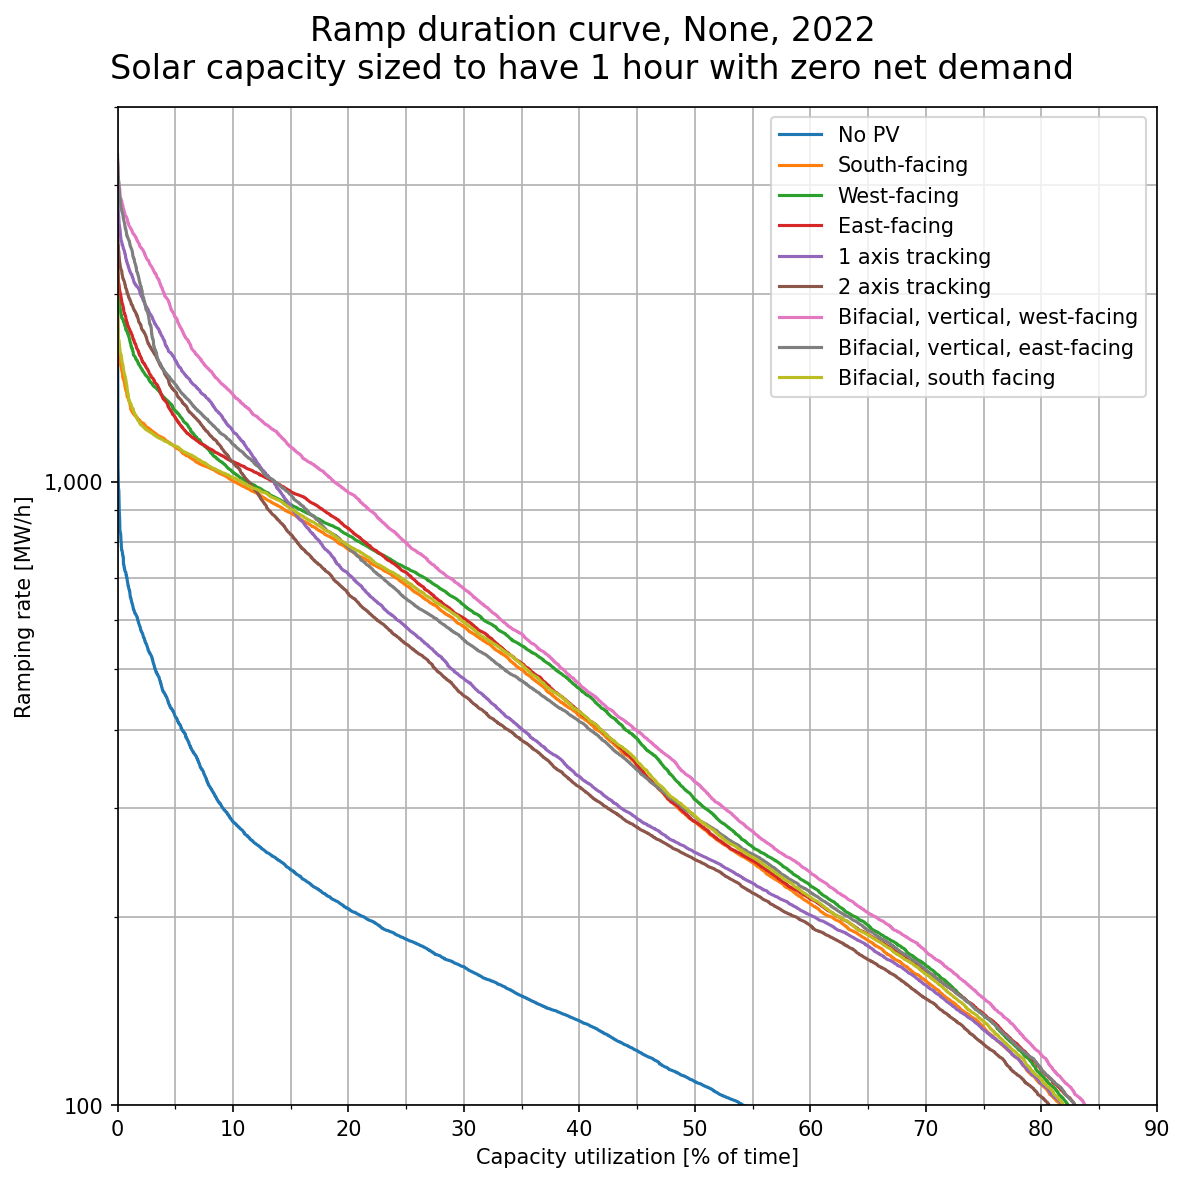

In [17]:
# Rampa máxima
b = np.abs( df[["Demand_dt"] + track_net_demand_dt] ).max(axis = 0)
b.index = ["No PV"] + names_dn
pd.options.display.float_format = '{:,.0f} MW/h'.format
print("Maximum ramp")
print( b.sort_values().to_string() )

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 8)
fig.set_dpi(150) 

# Iteramos para cada caso
for v in ["Demand_dt"] + track_net_demand_dt:
    a = np.abs(df[[v]]).sort_values( v,
        ascending = False ).reset_index(drop = True)
    a = a.where(a>0, 0)
    a.index = a.index / a.index.max() * 100
    ax.plot(a.index, a[v])

# Formato de gráfica
ax.legend( ["No PV"] + names_dn )
ax.set_yscale("log")
ax.set_xlim(0, 90)
ax.set_ylim(100, 4000)
ax.grid("both", "both")
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("Ramping rate [MW/h]")
ax.set_xlabel("Capacity utilization [% of time]")
fig.suptitle(f"Ramp duration curve, {reg}, 2022\n"
    + "Solar capacity sized to have 1 hour with zero net demand",
    fontsize = 16)
fig.tight_layout()
plt.show()